In [1]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("CUDA device count:", torch.cuda.device_count())
    print("Current CUDA device:", torch.cuda.current_device())
    print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available. Check your installation.")


PyTorch version: 2.7.0+cu128
CUDA available: True
CUDA device count: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce RTX 5080


In [33]:
import gymnasium as gym


# Use Gymnasium's built-in vectorization
num_envs = 8
env_name = "Pendulum-v1"    

# Create vectorized environment using Gymnasium's native support
#envs = gym.make_vec(env_name, num_envs=num_envs)
#print("Vectorized environment created")
env = gym.make(env_name)
# Reset should now work properly
#state = envs.reset()
state = env.reset()
if isinstance(state, tuple):
    state, info = state
print("State shape:", state.shape)
print("Number of environments:", len(state))

# Create a separate environment for visualization with render_mode
env_render = gym.make(env_name, render_mode="rgb_array")

State shape: (3,)
Number of environments: 3


In [15]:
use_cuda = torch.cuda.is_available()
print("Using CUDA:", use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
print("Device:", device)

Using CUDA: True
Device: cuda


In [16]:
# num_inputs = envs.observation_space.shape[0]
# num_actions = envs.action_space.shape[0]
num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]

print("Number of inputs:", num_inputs)
print("Number of actions:", num_actions)

Number of inputs: 3
Number of actions: 1


In [17]:
# declare the policy and value networks here
import torch.nn as nn
import torch.nn.functional as F


class Policy(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(num_inputs, 64)
        self.affine2 = nn.Linear(64, 64)

        self.action_mean = nn.Linear(64, num_outputs)
        self.action_mean.weight.data.mul_(0.1) # initialize small weights
        self.action_mean.bias.data.mul_(0.0) # initialize bias to zero

        self.action_log_std = nn.Parameter(torch.zeros(1, num_outputs))

        self.saved_actions = []
        self.rewards = []
        self.final_value = 0

    def forward(self, x):
        x = F.tanh(self.affine1(x))
        x = F.tanh(self.affine2(x))

        action_mean = self.action_mean(x)
        action_log_std = self.action_log_std.expand_as(action_mean)
        action_std = torch.exp(action_log_std)

        return action_mean, action_log_std, action_std
    

class Value(nn.Module):
    def __init__(self, num_inputs):
        super(Value, self).__init__()
        self.affine1 = nn.Linear(num_inputs, 64)
        self.affine2 = nn.Linear(64, 64)
        self.value_head = nn.Linear(64, 1)
        self.value_head.weight.data.mul_(0.1)
        self.value_head.bias.data.mul_(0.0)

    def forward(self, x):
        x = F.tanh(self.affine1(x))
        x = F.tanh(self.affine2(x))
        state_values = self.value_head(x)
        return state_values






policy_net = Policy(num_inputs, num_actions)
value_net = Value(num_inputs)

In [18]:
# define zfilter
import numpy as np


# from https://github.com/joschu/modular_rl
# http://www.johndcook.com/blog/standard_deviation/
class RunningStat(object):
    def __init__(self, shape):
        self._n = 0
        self._M = np.zeros(shape)
        self._S = np.zeros(shape)

    def push(self, x):
        x = np.asarray(x)
        assert x.shape == self._M.shape
        self._n += 1
        if self._n == 1:
            self._M[...] = x
        else:
            oldM = self._M.copy()
            self._M[...] = oldM + (x - oldM) / self._n
            self._S[...] = self._S + (x - oldM) * (x - self._M)

    @property
    def n(self):
        return self._n

    @property
    def mean(self):
        return self._M

    @property
    def var(self):
        return self._S / (self._n - 1) if self._n > 1 else np.square(self._M)

    @property
    def std(self):
        return np.sqrt(self.var)

    @property
    def shape(self):
        return self._M.shape


class ZFilter:
    """
    y = (x-mean)/std
    using running estimates of mean,std
    """

    def __init__(self, shape, demean=True, destd=True, clip=10.0):
        self.demean = demean
        self.destd = destd
        self.clip = clip

        self.rs = RunningStat(shape)

    def __call__(self, x, update=True):
        if update: self.rs.push(x)
        if self.demean:
            x = x - self.rs.mean
        if self.destd:
            x = x / (self.rs.std + 1e-8)
        if self.clip:
            x = np.clip(x, -self.clip, self.clip)
        return x

    def output_shape(self, input_space):
        return input_space.shape

running_state = ZFilter((num_inputs,), clip=5.0)
running_reward = ZFilter((1,), demean=False, clip=10.0)



In [19]:

from collections import namedtuple

Transition = namedtuple('Transition', ('state', 'action', 'mask', 'next_state', 'reward'))

class Memory(object):
    def __init__(self):
        self.memory = []

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self):
        return Transition(*zip(*self.memory))

    def __len__(self):
        return len(self.memory)

In [20]:
from torch.autograd import Variable


def get_flat_params_from(model):
    params = []
    for param in model.parameters():
        params.append(param.data.view(-1))

    flat_params = torch.cat(params)
    return flat_params


def set_flat_params_to(model, flat_params):
    prev_ind = 0
    for param in model.parameters():
        flat_size = int(np.prod(list(param.size())))
        param.data.copy_(
            flat_params[prev_ind:prev_ind + flat_size].view(param.size()))
        prev_ind += flat_size


def conjugate_gradients(Avp, b, nsteps, residual_tol=1e-10):
    x = torch.zeros(b.size())
    r = b.clone()
    p = b.clone()
    rdotr = torch.dot(r, r)
    for i in range(nsteps):
        _Avp = Avp(p)
        alpha = rdotr / torch.dot(p, _Avp)
        x += alpha * p
        r -= alpha * _Avp
        new_rdotr = torch.dot(r, r)
        betta = new_rdotr / rdotr
        p = r + betta * p
        rdotr = new_rdotr
        if rdotr < residual_tol:
            break
    return x


def linesearch(model, f, x, fullstep, expected_improve_rate, max_backtracks=10, accept_ratio=0.1):
    fval = f(True).data
    print("fval before", fval.item())
    for (_n_backtracks, stepfrac) in enumerate(.5 ** np.arange(max_backtracks)):
        xnew = x + stepfrac * fullstep
        set_flat_params_to(model, xnew)
        newfval = f(True).data
        actual_improve = fval - newfval
        expected_improve = expected_improve_rate * stepfrac
        ratio = actual_improve / expected_improve
        print("a/e/r", actual_improve.item(), expected_improve.item(), ratio.item())

        if ratio.item() > accept_ratio and actual_improve.item() > 0:
            print("fval after", newfval.item())
            return True, xnew
        
    return False, x

def trpo_step(model, get_loss, get_kl, max_kl, damping):
    loss = get_loss()
    grads = torch.autograd.grad(loss, model.parameters())
    loss_grad = torch.cat([grad.view(-1) for grad in grads]).data

    def Fvp(v):
        kl = get_kl()
        kl = kl.mean()

        grads = torch.autograd.grad(kl, model.parameters(), create_graph=True)
        flat_grad_kl = torch.cat([grad.view(-1) for grad in grads])

        kl_v = (flat_grad_kl * Variable(v)).sum()
        grads = torch.autograd.grad(kl_v, model.parameters())
        flat_grad_grad_kl = torch.cat([grad.contiguous().view(-1) for grad in grads]).data

        return flat_grad_grad_kl + v * damping
    
    stepdir = conjugate_gradients(Fvp, -loss_grad, 10)
    shs = 0.5 * (stepdir * Fvp(stepdir)).sum(0, keepdim=True)

    lm = torch.sqrt(shs / max_kl)
    fullstep = stepdir / lm[0]

    neggdotstepdir = (-loss_grad * stepdir).sum(0, keepdim=True)
    print(("lagrange multiplier:", lm[0], "grad_norm:", loss_grad.norm()))

    prev_params = get_flat_params_from(model)
    success, new_params = linesearch(model, get_loss, prev_params, fullstep, neggdotstepdir / lm[0])

    set_flat_params_to(model, new_params)

    return loss


In [25]:
import scipy.optimize
import math

gamma = 0.995
tau = 0.97
l2_reg = 1e-3
max_kl = 1e-2
damping = 1e-1


def normal_entropy(std):
    var = std.pow(2)
    entropy = 0.5 + 0.5 * torch.log(2 * var * math.pi)
    return entropy.sum(1, keepdim=True)


def normal_log_density(x, mean, log_std, std):
    var = std.pow(2)
    log_density = -(x - mean).pow(2) / (
        2 * var) - 0.5 * math.log(2 * math.pi) - log_std
    return log_density.sum(1, keepdim=True)





def get_flat_grad_from(net, grad_grad=False):
    grads = []
    for param in net.parameters():
        if grad_grad:
            grads.append(param.grad.grad.view(-1))
        else:
            grads.append(param.grad.view(-1))

    flat_grad = torch.cat(grads)
    return flat_grad

def select_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)  # Ensure float32 dtype
    action_mean, _, action_std = policy_net(Variable(state))
    action = torch.normal(action_mean, action_std)
    return action


def update_params(batch):
    rewards = torch.Tensor(batch.reward)
    masks = torch.Tensor(batch.mask)
    actions = torch.Tensor(np.concatenate(batch.action, 0))
    states = torch.Tensor(batch.state)
    values = value_net(Variable(states))

    returns = torch.Tensor(actions.size(0), 1)
    deltas = torch.Tensor(actions.size(0), 1)
    advantages = torch.Tensor(actions.size(0), 1)

    prev_return = 0
    prev_value = 0
    prev_advantage = 0
    for i in reversed(range(rewards.size(0))):
        returns[i] = rewards[i] + gamma * prev_return * masks[i]
        deltas[i] = rewards[i] + gamma * prev_value * masks[i] - values.data[i]
        advantages[i] = deltas[i] + gamma * tau * prev_advantage * masks[i]

        prev_return = returns[i, 0]
        prev_value = values.data[i, 0]
        prev_advantage = advantages[i, 0]

    targets = Variable(returns)


    def get_value_loss(flat_params):
        set_flat_params_to(value_net, torch.Tensor(flat_params))
        for param in value_net.parameters():
            if param.grad is not None:
                param.grad.data.fill_(0)

        values = value_net(Variable(states))

        value_loss = (values - targets).pow(2).mean()

        # weight decay
        for param in value_net.parameters():
            value_loss += param.pow(2).sum() * l2_reg
        value_loss.backward()
        return (value_loss.data.double().numpy(), get_flat_grad_from(value_net).data.double().numpy())

    flat_params, _, opt_info = scipy.optimize.fmin_l_bfgs_b(get_value_loss, get_flat_params_from(value_net).double().numpy(), maxiter=25)
    set_flat_params_to(value_net, torch.Tensor(flat_params))

    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-5)

    action_means, action_log_stds, action_stds = policy_net(Variable(states))
    fixed_log_prob = normal_log_density(Variable(actions), action_means, action_log_stds, action_stds).data.clone()

    def get_loss(volatile=False):
        if volatile:
            with torch.no_grad():
                action_means, action_log_stds, action_stds = policy_net(Variable(states))
        else:
            action_means, action_log_stds, action_stds = policy_net(Variable(states))

        log_prob = normal_log_density(Variable(actions), action_means, action_log_stds, action_stds)
        action_loss = -Variable(advantages) * torch.exp(log_prob - Variable(fixed_log_prob))
        return action_loss.mean()
    
    def get_kl():
        mean1, log_std1, std1 = policy_net(Variable(states))

        mean0 = Variable(mean1.data)
        log_std0 = Variable(log_std1.data)
        std0 = Variable(std1.data)
        kl = log_std1 - log_std0 + (std0.pow(2) + (mean0 - mean1).pow(2)) / (2.0 * std1.pow(2)) - 0.5
        return kl.sum(1, keepdim=True)
    
    trpo_step(policy_net, get_loss, get_kl, max_kl, damping)




In [26]:
from itertools import count


batch_size = 15_000
render = False
log_interval = 10

for i_episode in count(1):
    memory = Memory()

    num_steps = 0
    reward_batch = 0
    num_episodes = 0
    while num_steps < batch_size:
        state = env.reset()
        # Handle tuple return from env.reset()
        if isinstance(state, tuple):
            state, info = state
        state = running_state(state)

        reward_sum = 0
        for t in range(10_000):
            action = select_action(state)
            action = action.data[0].numpy()
            next_state, reward, done, truncated, info = env.step(action) #should i bring back to cpu?
            reward_sum += reward
            next_state = running_state(next_state)

            mask = 1
            if done:
                mask = 0

            memory.push(state, np.array([action]), mask, next_state, reward)

            if render:
                env.render()

            if done:
                break

            state = next_state
        num_steps += (t + 1)
        num_episodes += 1
        reward_batch += reward_sum

    reward_batch /= num_episodes
    batch = memory.sample()
    update_params(batch)

    if i_episode % log_interval == 0:
        print('Episode {}\tLast reward: {}\tAverage reward: {:.2f}'.format(
              i_episode, reward_sum, reward_batch))

/tmp/ipykernel_2128798/822351018.py:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states = torch.Tensor(batch.state)


('lagrange multiplier:', tensor(0.1916), 'grad_norm:', tensor(0.0288))
fval before -6.337165814329637e-08
a/e/r 0.003798785386607051 0.0038328589871525764 0.9911101460456848
fval after -0.0037988487165421247
('lagrange multiplier:', tensor(0.1176), 'grad_norm:', tensor(0.0161))
fval before -1.2302399099439754e-08
a/e/r 0.0023057337384670973 0.0023523697163909674 0.9801748991012573
fval after -0.002305746078491211
('lagrange multiplier:', tensor(0.1176), 'grad_norm:', tensor(0.0161))
fval before -1.2302399099439754e-08
a/e/r 0.0023057337384670973 0.0023523697163909674 0.9801748991012573
fval after -0.002305746078491211
('lagrange multiplier:', tensor(0.5621), 'grad_norm:', tensor(0.1088))
fval before -8.583068700218632e-10
a/e/r 0.011227909475564957 0.011242453008890152 0.9987064003944397
fval after -0.011227910406887531
('lagrange multiplier:', tensor(0.5621), 'grad_norm:', tensor(0.1088))
fval before -8.583068700218632e-10
a/e/r 0.011227909475564957 0.011242453008890152 0.998706400394

KeyboardInterrupt: 

In [29]:
device

device(type='cuda')

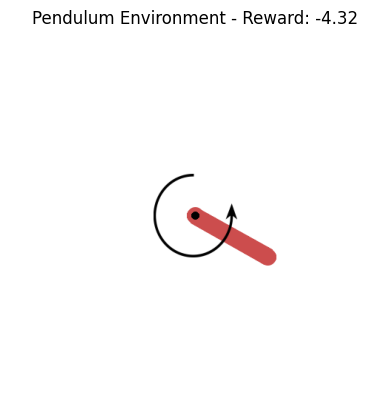

In [36]:
import time
from matplotlib import pyplot as plt
from IPython.display import clear_output
import torch.distributions as dist

# test the trained policy over the environment
obs, info = env_render.reset()
print("Observation space:", obs.shape)
print("Info:", info)

# Run a test episode and display it in real-time
done = False
start_time = time.time()

# Create figure once
plt.figure(figsize=(8, 6))

while time.time() - start_time < 30:  # Run for 10 seconds
    # Convert observation to tensor and get policy outputs
    state = torch.FloatTensor(obs).unsqueeze(0)
    action_mean, action_log_std, action_std = policy_net(state)
    
    # Create normal distribution and sample action
    action_dist = dist.Normal(action_mean, action_std)
    action = action_dist.sample().cpu().numpy()[0]
    
    # Take step in environment
    obs, reward, done, truncated, info = env_render.step(action)
    
    # Get frame and display it
    frame = env_render.render()
    
    # Clear previous plot and show new frame
    clear_output(wait=True)
    plt.imshow(frame)
    plt.axis('off')
    plt.title(f'Pendulum Environment - Reward: {reward:.2f}')
    plt.show()
    
    # Reset if episode ends
    if done or truncated:
        obs, info = env_render.reset()
    
    time.sleep(0.05)  # Small delay to see the animation